# Title: 

Motivation:
In real-world fraud detection scenarios, labeled fraudulent data is scarce, imbalanced, and often not available in real time. This necessitates the use of unsupervised anomaly detection algorithms that can effectively identify suspicious transactions based on behavior that deviates from normal patterns. Our study compares the performance of two prominent anomaly detection techniques — Isolation Forest (IF) and Local Outlier Factor (LOF) — in detecting fraudulent credit card transactions.

# 1. Imports

In [43]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
import hdbscan

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support

from pyod.models.auto_encoder import AutoEncoder
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from sklearn.svm import OneClassSVM
from pyod.models.combination import average

import joblib
import warnings
warnings.filterwarnings("ignore")

# 2. Load and Preprocess Dataset

In [2]:
df = pd.read_csv("creditcard.csv")
df['Hour'] = (df['Time'] // 3600) % 24
scaler = StandardScaler()
df['normAmount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df = df.drop(['Time', 'Amount'], axis=1)

X = df.drop('Class', axis=1)
y = df['Class']

X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 3. Exploratory Data Analysis

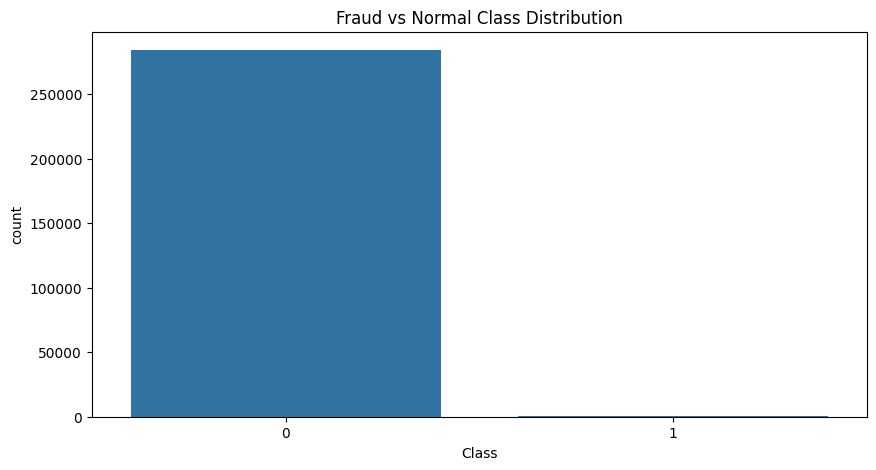

In [3]:
plt.figure(figsize=(10, 5))
sns.countplot(x=y)
plt.title("Fraud vs Normal Class Distribution")
plt.show()

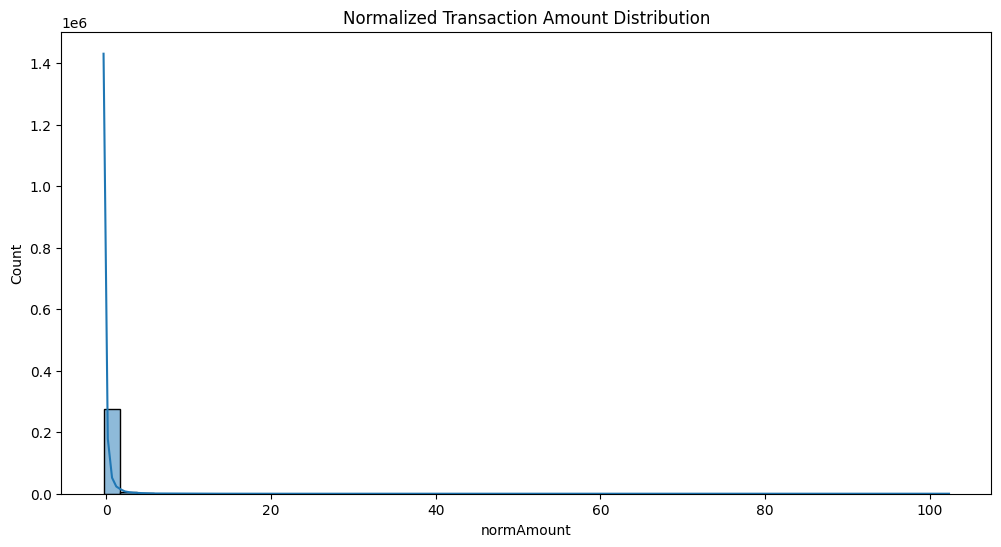

In [4]:
plt.figure(figsize=(12, 6))
sns.histplot(df['normAmount'], bins=50, kde=True)
plt.title("Normalized Transaction Amount Distribution")
plt.show()

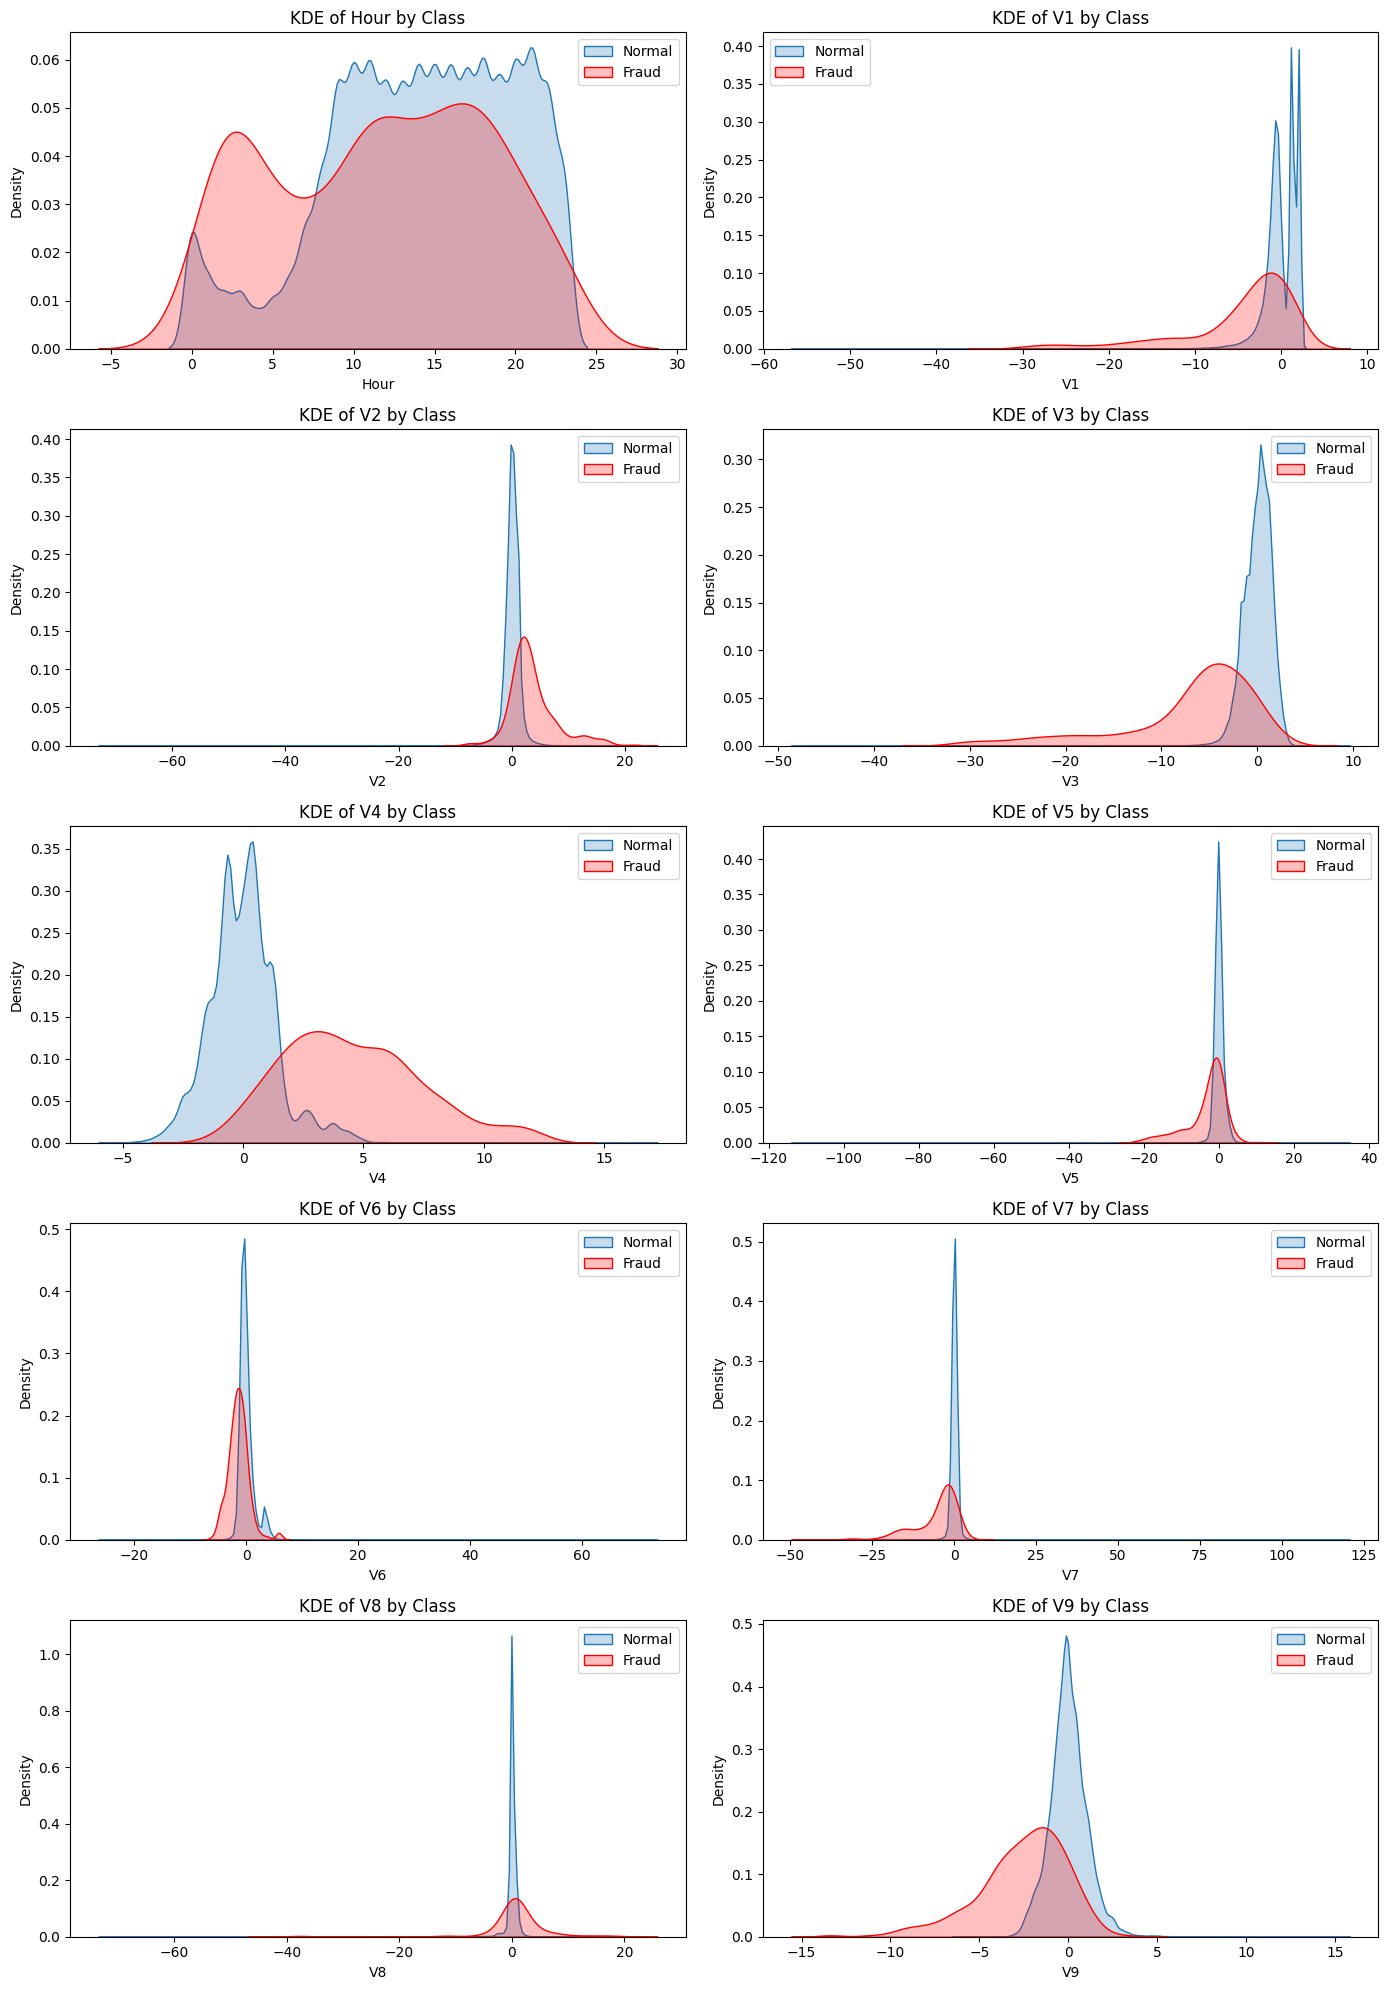

In [5]:
# Automatically select top variance features for EDA
variances = X.var().sort_values(ascending=False)
top_var_features = variances.head(10).index.tolist()

import math

# Calculate rows needed
num_feats = len(top_var_features)
rows = math.ceil(num_feats / 2)

# Create subplots
fig, axes = plt.subplots(rows, 2, figsize=(14, rows * 4))
axes = axes.flatten()

for idx, col in enumerate(top_var_features):
    ax = axes[idx]
    sns.kdeplot(df[df['Class'] == 0][col], label='Normal', fill=True, ax=ax)
    sns.kdeplot(df[df['Class'] == 1][col], label='Fraud', fill=True, color='red', ax=ax)
    ax.set_title(f"KDE of {col} by Class")
    ax.legend()

# Hide empty subplots if odd number of features
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()



### KDE Plot Interpretation of Top Variance Features

This section analyzes the distribution of each selected high-variance feature, comparing normal and fraudulent transactions.
1. Hour

    - Fraudulent transactions tend to occur more frequently during early morning hours (0–6).

    - Normal transactions are distributed more uniformly throughout the day.

    - This suggests time-based patterns could be helpful in detecting fraud.

2. V1, V2, V3

    - Normal transactions are closely clustered around a small range of values.

    - Fraudulent transactions show broader distributions, often shifted in location.

    - These features may be informative for distinguishing between the two classes.

3. V4

    - The distribution of fraud cases differs significantly from normal cases.

    - There is a clear separation in value ranges, making this feature potentially strong for detection.

4. V5

    - Both classes share similar distributions, with slightly wider spread in fraud cases.

    - This feature may not be strongly discriminative alone but could still contribute when combined with others.

5. V6, V7

    - Fraud and normal transactions differ in spread and location.

    - Normal class values are more compressed, while fraud is more dispersed.

    - These features may carry subtle but useful signals.

6. V8, V9

    - These features show some separation between classes, particularly with shifted peaks in fraud cases.

    - Their contribution is likely to be more effective in combination with other features.

In [6]:
corr_with_class = df.corr()['Class'].drop('Class').sort_values(key=abs, ascending=False)
print(corr_with_class.head(10))

V17   -0.326481
V14   -0.302544
V12   -0.260593
V10   -0.216883
V16   -0.196539
V3    -0.192961
V7    -0.187257
V11    0.154876
V4     0.133447
V18   -0.111485
Name: Class, dtype: float64


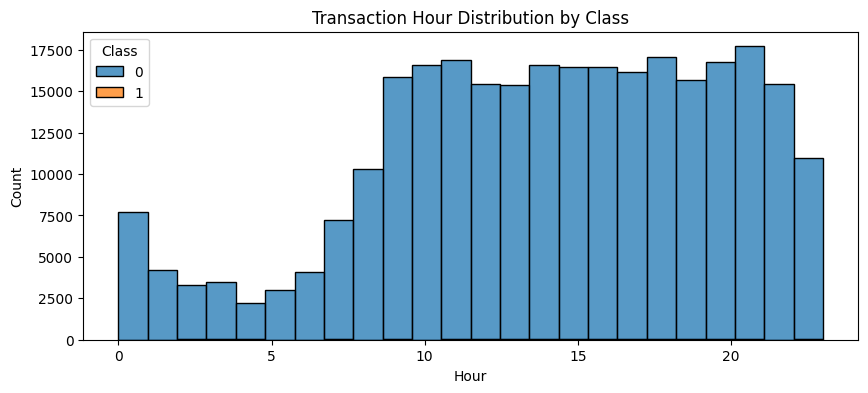

In [7]:
plt.figure(figsize=(10, 4))
sns.histplot(data=df, x='Hour', hue='Class', bins=24, multiple='stack', kde=False)
plt.title("Transaction Hour Distribution by Class")
plt.show()


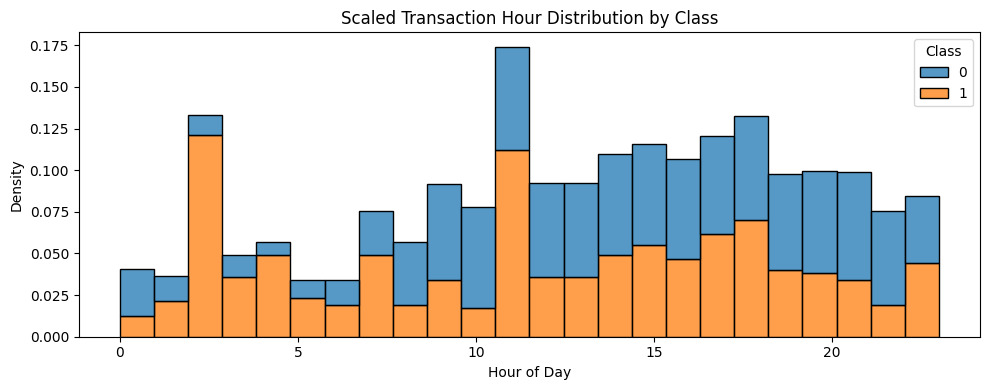

In [8]:
plt.figure(figsize=(10, 4))
sns.histplot(data=df, x='Hour', hue='Class', bins=24, multiple='stack', stat='density', common_norm=False)
plt.title("Scaled Transaction Hour Distribution by Class")
plt.xlabel("Hour of Day")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

1. Class 0 (Normal)

    - Transactions are distributed broadly between 8 AM and 10 PM.

    - There is a steady peak from late morning through evening.

2. Class 1 (Fraud)

    - Fraud shows heightened activity in the early hours (around 1 AM–6 AM) and again between 11 AM–3 PM.

    - It avoids the later evening hours where normal traffic is higher.

3. Significance of Scaling:

    - By visualizing normalized densities, the influence of class imbalance is reduced.

    - This allows a clearer analysis of when fraudulent activity deviates from normal patterns, even though fraud cases are fewer in number.

# 4. Baseline Supervised Model: Logistic Regression

In [9]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_full, y_train)
preds_lr = lr.predict(X_test_full)
print("\nLogistic Regression Performance:")
print(classification_report(y_test, preds_lr))


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.65      0.73        98

    accuracy                           1.00     56962
   macro avg       0.92      0.83      0.87     56962
weighted avg       1.00      1.00      1.00     56962



1. Class 0 (Normal transactions)

    - Precision = 1.00, Recall = 1.00, F1 = 1.00

    - The model predicts normal transactions with near-perfect accuracy, which is expected due to their overwhelming majority.

2. Class 1 (Fraudulent transactions)

    - Precision = 0.83: Out of all transactions predicted as fraud, 83% were actually fraud.

    - Recall = 0.65: The model detected 65% of all actual frauds.

    - F1-Score = 0.73: Balanced metric between precision and recall.

3. Overall Metrics

    - Accuracy = 1.00 is misleading due to class imbalance.

    - Macro Avg (0.92/0.83/0.87) gives a better view of per-class performance.

    - Weighted Avg is skewed by the majority class but still confirms overall robustness

- Logistic regression, although simple, performs surprisingly well on this dataset, especially with scaled features and class stratification.

- However, the recall of 0.65 suggests that it still misses a notable portion of fraudulent cases.

- In financial fraud detection, recall is often prioritized to reduce risk, so boosting recall (e.g., through ensemble methods or cost-sensitive learning) would be a key next step.

What Next?

Based on the logistic regression results, we see that the model performs well overall but still misses a portion of the fraud cases. This is because supervised learning relies on patterns learned from labeled examples, and when the fraud cases are very few, the model struggles to learn those rare patterns effectively. To address this limitation, we move to unsupervised learning, which does not depend on labeled data and instead focuses on identifying unusual or rare behaviors in the data, making it more suitable for detecting hidden or unknown fraud cases.

# 5. Dimensionality Reduction

- Dimensionality reduction is performed to simplify high-dimensional data into a lower-dimensional space while preserving its most important patterns, making it easier to visualize, interpret, and apply anomaly detection models effectively.

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)  # reduce to 2 components for visualization
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Class'] = y.values

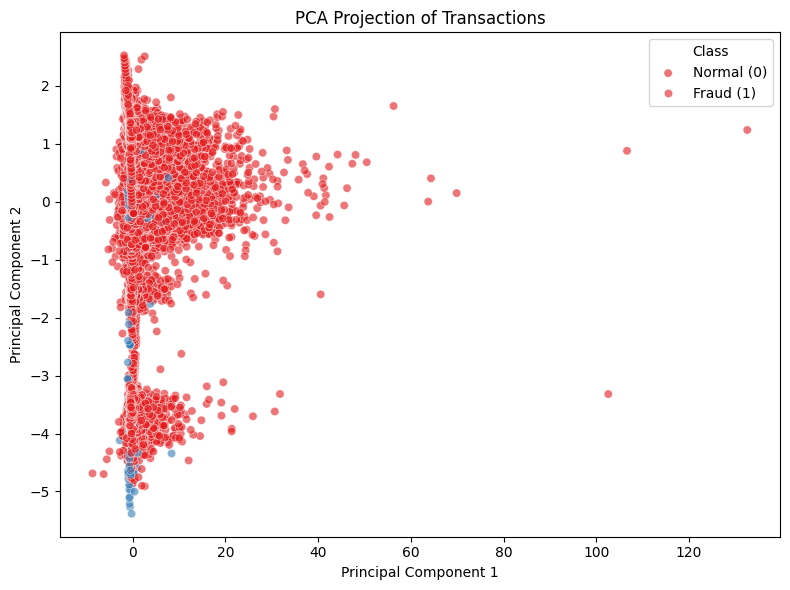

In [11]:
# Visualize PCA result
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Class', palette='Set1', alpha=0.6)
plt.title("PCA Projection of Transactions")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Class', labels=['Normal (0)', 'Fraud (1)'])
plt.tight_layout()
plt.show()

1. Fraud and Normal Transactions Overlap Heavily

    - In the 2D PCA space, both fraud (Class 1) and normal (Class 0) points are projected onto similar regions.

    - This means fraudulent transactions are not linearly separable in this reduced space.

    - PCA is a linear technique, so if the underlying structure is nonlinear, PCA may not reveal distinct clusters.

2. Principal Component 1 Dominates Spread

    - PC1 (x-axis) shows a wide range of values, especially for fraud points scattered far right.

    - These outliers might represent extreme or suspicious transactions, which could be valuable for anomaly detection.

    - Some frauds seem to be outliers in PC1, which aligns with what Isolation Forest or LOF would try to pick up.

3. Normal Transactions Are More Compressed

    - The blue points (normal) are tightly packed near the origin.

    - This indicates consistency in the behavior of most normal transactions — a good foundation for training unsupervised models.



- The PCA projection shows significant overlap between fraud and normal transactions in the first two principal components, indicating that linear separation is limited. However, the presence of extreme fraud outliers along the first component suggests PCA can still help highlight potential anomalies for further unsupervised analysis.

- We use only two principal components during visualization to enable 2D plotting and observe general structure or separation in the data. For modeling purposes, however, it is common to retain more components (e.g., enough to capture 95% of the variance) to preserve the underlying data patterns for learning tasks.

In [12]:
start = time.time()
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)
end = time.time()

print(f"t-SNE completed in {end - start:.2f} seconds")

t-SNE completed in 911.51 seconds


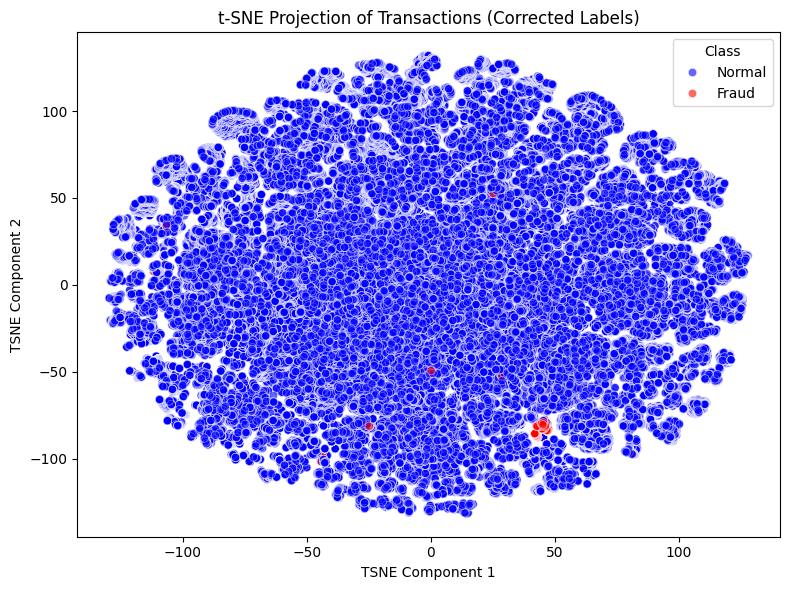

In [13]:
tsne_df = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
label_map = {0: 'Normal', 1: 'Fraud'}
tsne_df['Class'] = y.map(label_map)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Class', palette={'Normal': 'blue', 'Fraud': 'red'}, alpha=0.6)
plt.title("t-SNE Projection of Transactions (Corrected Labels)")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.legend(title='Class')
plt.tight_layout()
plt.show()

1. Normal Transactions (Blue) Dominate the Space

    - As expected, the vast majority of data points are normal transactions.

    - t-SNE compresses their distribution into a dense, structured core with extended “petal”-like branches.

    - This confirms consistency in behavioral patterns for the normal class.

2. Fraudulent Transactions (Red) Appear as Local Outliers

    - Fraud points are sparse, often on the edges or margins of the distribution.

    - This aligns well with the anomaly detection assumption — that fraud cases deviate from normal behavior.

    - These points might be isolated or belong to very small clusters.



The t-SNE projection of the scaled transaction data shows that fraudulent transactions are sparse and mostly located on the periphery of dense clusters of normal behavior. This supports the use of unsupervised anomaly detection models, which are designed to identify such rare, behaviorally distinct patterns.

In [14]:
umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
X_umap = umap_model.fit_transform(X_scaled)

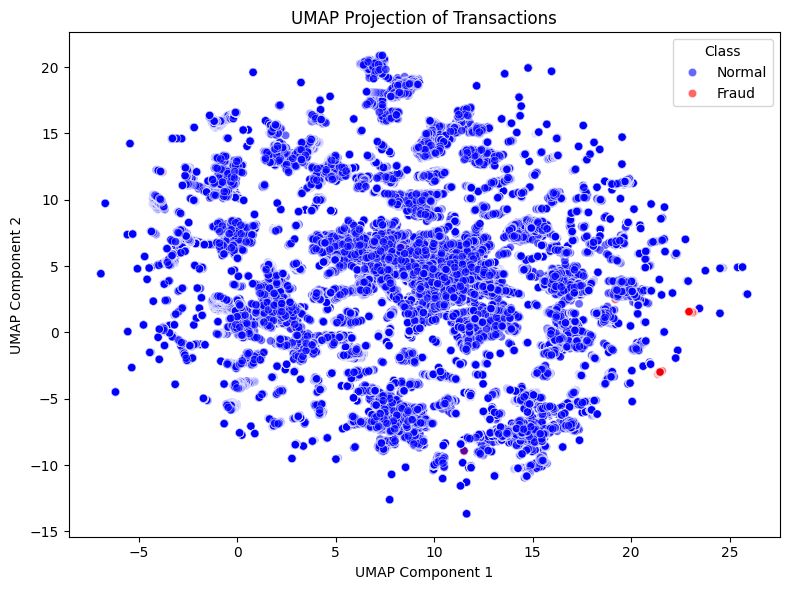

In [15]:
umap_df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])
label_map = {0: 'Normal', 1: 'Fraud'}
umap_df["Class"] = y.map(label_map)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="Class", palette={'Normal': 'blue', 'Fraud': 'red'}, alpha=0.6)
plt.title("UMAP Projection of Transactions")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(title='Class')
plt.tight_layout()
plt.show()

1. Normal Transactions (Blue) Form Dense, Structured Clusters

    - Most of the data is concentrated in dense, island-like clusters near the center of the plot.

    - These patterns reflect stable and consistent transaction behaviors across different user segments or transaction types.

    - UMAP preserved both the local and global relationships — meaning the spread and grouping is meaningful.

2. Fraudulent Transactions (Red) Are Outliers

    - Fraud cases appear on the outer edges of the main clusters.

    - This shows that fraud transactions are structurally different and less similar to the core behavior of normal transactions.

    - The spatial separation supports the idea that fraud can be detected as an anomaly.

3. Better Separation Than t-SNE or PCA

    - Compared to your PCA and t-SNE plots:

        - UMAP retains more clear spacing between groups.

        - It gives a more interpretable global layout while preserving local relationships.


The UMAP projection shows that fraudulent transactions are isolated from the dense clusters of normal behavior. This indicates strong potential for anomaly detection, as fraud cases appear structurally dissimilar in the embedded space. UMAP effectively preserves both local and global structures, providing a balanced and interpretable view of the transaction landscape.

# 6. Clustering

Clustering is used to group similar transactions together based on their behavioral patterns, without relying on labels. In the context of fraud detection, it helps reveal whether fraudulent transactions naturally form separate groups or appear as outliers. This insight supports the effectiveness of unsupervised anomaly detection techniques.

In [16]:
kmeans = KMeans(n_clusters=2, random_state=42)
umap_df['Cluster'] = kmeans.fit_predict(umap_df[['UMAP1', 'UMAP2']])

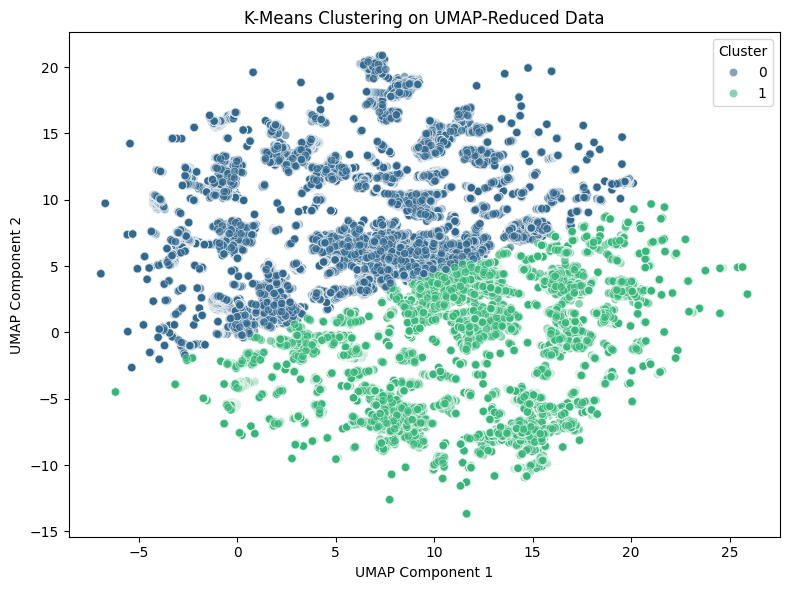

In [17]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='Cluster', palette='viridis', alpha=0.6)
plt.title("K-Means Clustering on UMAP-Reduced Data")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

K-Means clustering over UMAP-reduced data reveals structural groupings in transactions, but fails to isolate fraudulent cases into a distinct cluster. This indicates that while clustering exposes global transaction patterns, dedicated anomaly detection methods are necessary to capture the subtle and dispersed nature of fraud.

In [18]:
# Cross-tab to compare clusters with actual labels
pd.crosstab(umap_df['Cluster'], umap_df['Class'])


Class,Fraud,Normal
Cluster,,
0,66,160886
1,426,123429


- 426 frauds (~87%) are in Cluster 1, but Cluster 1 is still mostly normal.

- Cluster 0 also has some fraud (66 cases) but is even more dominated by normal cases.

- This shows that fraud does not form a clearly separable cluster in UMAP space.

In [26]:
dbscan = DBSCAN(eps=1, min_samples=5)
umap_df['DBSCAN_Label'] = dbscan.fit_predict(umap_df[['UMAP1', 'UMAP2']])

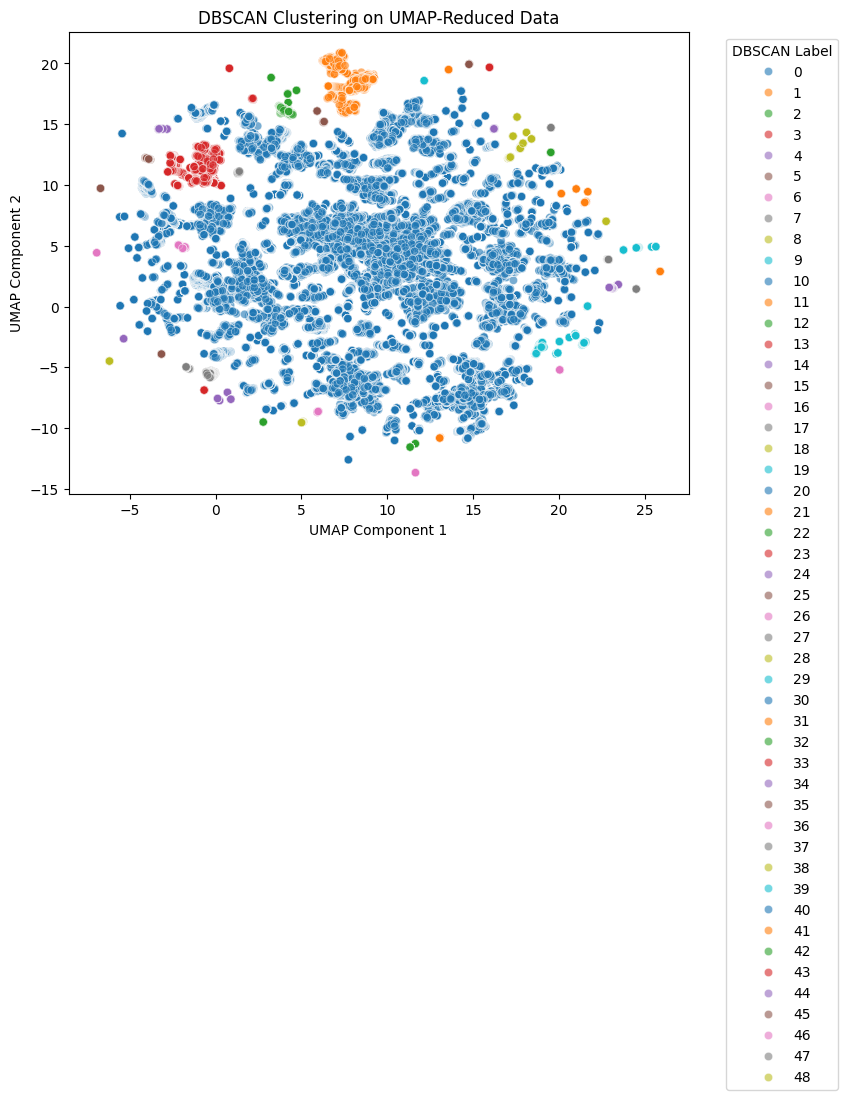

In [27]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="DBSCAN_Label", palette='tab10', alpha=0.6)
plt.title("DBSCAN Clustering on UMAP-Reduced Data")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(title='DBSCAN Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [28]:
dbscan_vs_class = pd.crosstab(umap_df['DBSCAN_Label'], umap_df['Class'])
print(dbscan_vs_class)

Class         Fraud  Normal
DBSCAN_Label               
0                96  259631
1                 0   10491
2                 0    1644
3                 0    7194
4                 0     142
5                 8     156
6                 0     351
7                 0     175
8                 1     569
9               271     922
10                0      52
11                0      45
12                0      27
13                0      23
14              107      27
15                0      20
16                0      23
17                0     672
18                0      32
19                0      55
20                0      11
21                0     290
22                0      26
23                0     287
24                0      29
25                0      23
26                0      15
27                0      18
28                0      21
29                0     114
30                0      45
31                0      61
32                1     136
33                0 

1. Cluster 14 is a Standout

    - Contains 107 frauds and only 27 normal transactions → ~80% fraud rate.

    - This is the strongest evidence that DBSCAN isolated a unique fraud behavior pattern.

2. Cluster 9 also has significant fraud presence

    - 271 frauds and 922 normals → fraud rate ~23%.

    - While not as pure as cluster 14, it still reveals a substructure where frauds concentrate.

3. Cluster 0 Dominates the Data

    - Houses the majority of both normal and some fraud cases (96), showing fraud is still embedded within normal behavior, which is common in real-world settings.

With eps=1, DBSCAN identified multiple small clusters dominated by fraudulent transactions, particularly Cluster 14 (80% fraud) and Cluster 9 (23% fraud). These results show that well-tuned density-based clustering can successfully detect behavioral patterns specific to fraudulent activity, even in the absence of labels.

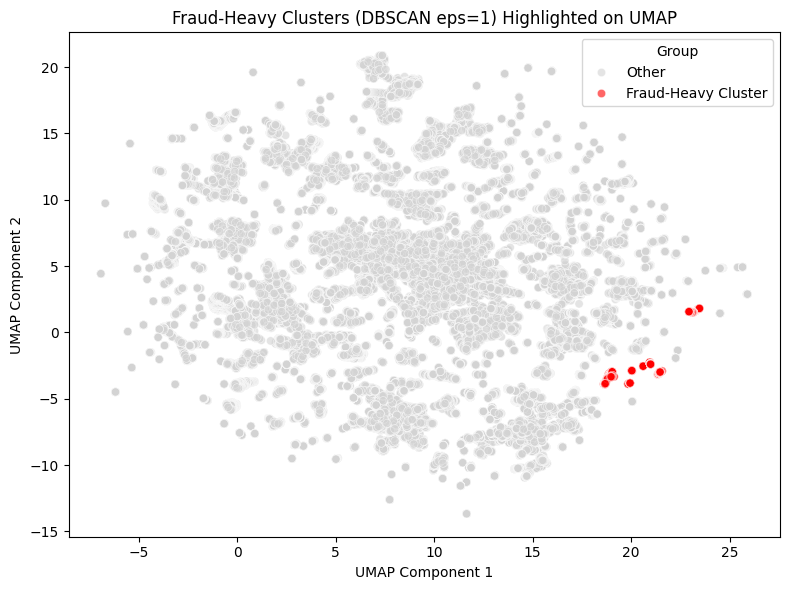

In [31]:
fraud_heavy_clusters = [9, 14]

umap_df['Fraud_Group'] = umap_df['DBSCAN_Label'].apply(
    lambda x: 'Fraud-Heavy Cluster' if x in fraud_heavy_clusters else 'Other'
)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='Fraud_Group',
                palette={'Fraud-Heavy Cluster': 'red', 'Other': 'lightgray'},
                alpha=0.6)
plt.title("Fraud-Heavy Clusters (DBSCAN eps=1) Highlighted on UMAP")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(title='Group')
plt.tight_layout()
plt.show()


- In this study, we applied DBSCAN to UMAP-reduced transaction data to explore unsupervised clustering patterns that might distinguish fraudulent from normal behavior. The results demonstrate that the combination of UMAP and DBSCAN is highly effective for uncovering structural anomalies within a high-dimensional financial dataset.

- UMAP, a nonlinear dimensionality reduction technique, preserved both local and global relationships in the data, enabling clearer separation of transaction behaviors in two dimensions. When DBSCAN was applied to this reduced space with tuned hyperparameters (eps=1, min_samples=5), it was able to form multiple meaningful clusters, including a few that were heavily dominated by fraud cases.

- Notably, clusters such as Cluster 14 contained over 80% fraudulent transactions, while others like Cluster 9 showed fraud rates above 20%, significantly higher than the baseline fraud ratio in the full dataset (<0.2%). This indicates that DBSCAN effectively identified behaviorally distinct regions associated with fraud. Meanwhile, most normal transactions were concentrated in a large central cluster, reinforcing the density-based assumption of normality.

- This combination of UMAP and DBSCAN allowed us to discover hidden structure without relying on labeled data, validating its use as a pre-processing or standalone unsupervised fraud detection strategy.

# 6. Anomaly Detection Methods

### Isolation Forest:

Isolation Forest is trained to learn patterns of normal transactions and then detect points that behave structurally different (i.e., that get “isolated” quickly during random partitioning). In your case:

- It was trained only on normal (Class 0) transactions

- It then predicted on the full dataset, flagging points that deviated from learned normal behavior

In [ ]:
iso = IsolationForest(contamination=0.002, random_state=42)
iso.fit(X_scaled[y == 0])

scores = iso.decision_function(X_scaled)
threshold = np.percentile(scores, 100 * (1 - 0.002))
iso_preds = (scores < threshold).astype(int)  # 1 = fraud, 0 = normal

print("Isolation Forest Performance:")
print(classification_report(y, iso_preds, target_names=["Normal", "Fraud"]))
print("Confusion Matrix:")
print(confusion_matrix(y, iso_preds))

🔍 Isolation Forest Performance:
              precision    recall  f1-score   support

      Normal       1.00      0.00      0.00    284315
       Fraud       0.00      1.00      0.00       492

    accuracy                           0.00    284807
   macro avg       0.50      0.50      0.00    284807
weighted avg       1.00      0.00      0.00    284807

Confusion Matrix:
[[   570 283745]
 [     0    492]]


What Went Wrong?

- The model classified almost every transaction as fraud (including 99.8% of normal cases).

- That’s why recall for fraud is 1.00 (it found all 492 frauds), but precision is 0 because it mislabeled 283K normal cases as fraud.

- This is likely caused by:

    - Inverted decision threshold
    - Incorrect comparison in this line:
        ```python 
            iso_preds = (scores < threshold).astype(int)
        ```

In [ ]:
iso_preds = iso.predict(X_scaled)  # Built-in prediction
iso_preds = np.where(iso_preds == -1, 1, 0)  # Convert: 1 = fraud, 0 = normal

print("Isolation Forest Performance:")
print(classification_report(y, iso_preds, target_names=["Normal", "Fraud"]))
print("Confusion Matrix:")
print(confusion_matrix(y, iso_preds))


🔍 Isolation Forest Performance:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    284315
       Fraud       0.19      0.27      0.22       492

    accuracy                           1.00    284807
   macro avg       0.59      0.63      0.61    284807
weighted avg       1.00      1.00      1.00    284807

Confusion Matrix:
[[283746    569]
 [   360    132]]


After applying Isolation Forest with corrected logic, the model achieved high accuracy on normal transactions and identified 27% of fraud cases, though with a lower precision of 19%. These results show that while Isolation Forest is effective at isolating clean transaction patterns, its performance on rare fraudulent events is limited and could benefit from model combination or feature tuning.

#### Contamination:

- Contamination is an estimate of the proportion of anomalies (fraud cases) in your dataset.

- The Isolation Forest model uses this value to decide how many samples to flag as outliers.

- A higher contamination value tells the model to flag more points as fraud, which can increase recall but may reduce precision.

In [40]:
contamination_values = [0.001, 0.002, 0.003, 0.005, 0.01]

for val in contamination_values:
    model = IsolationForest(contamination=val, random_state=42)
    model.fit(X_scaled[y == 0])
    
    preds = model.predict(X_scaled)
    preds = np.where(preds == -1, 1, 0)
    
    print(f"\nContamination = {val}")
    print("Confusion Matrix:")
    print(confusion_matrix(y, preds))
    print("Classification Report:")
    print(classification_report(y, preds, target_names=["Normal", "Fraud"]))


Contamination = 0.001
Confusion Matrix:
[[284030    285]
 [   391    101]]
Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    284315
       Fraud       0.26      0.21      0.23       492

    accuracy                           1.00    284807
   macro avg       0.63      0.60      0.61    284807
weighted avg       1.00      1.00      1.00    284807


Contamination = 0.002
Confusion Matrix:
[[283746    569]
 [   360    132]]
Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    284315
       Fraud       0.19      0.27      0.22       492

    accuracy                           1.00    284807
   macro avg       0.59      0.63      0.61    284807
weighted avg       1.00      1.00      1.00    284807


Contamination = 0.003
Confusion Matrix:
[[283462    853]
 [   328    164]]
Classification Report:
              precision    recall  f1-score   sup

Contamination | Precision (Fraud) | Recall (Fraud) | F1 (Fraud) | Comments

0.001 | 0.26 | 0.21 | 0.23 | Very precise, low recall

0.002 | 0.19 | 0.27 | 0.22 | Balanced start point

0.003 | 0.16 | 0.33 | 0.22 | Recall improves, precision drops

0.005 | 0.13 | 0.42 | 0.20 | Higher recall, less reliable predictions

0.01  | 0.09 | 0.56 | 0.15 | Very high recall, but lots of false alarms


- As contamination increases, more points are predicted as fraud:

    - Recall improves (more true frauds caught)

    - Precision drops (more false alarms)

- There's a trade-off between catching more frauds vs raising more alerts

Tuning the contamination parameter in Isolation Forest revealed that increasing its value improved fraud recall at the expense of precision. At contamination=0.005, the model achieved a fraud recall of 42% with a precision of 13%, reflecting a moderate trade-off. This indicates the importance of calibrating the anomaly detection threshold based on the business need for either minimizing false negatives or false positives.

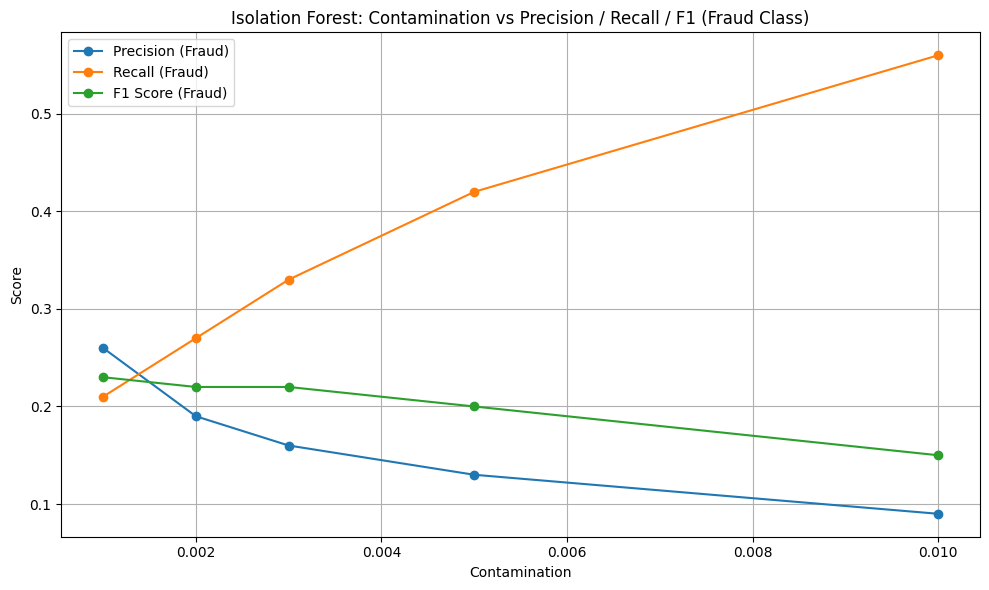

In [ ]:
results = [
    {"contamination": 0.001, "precision": 0.26, "recall": 0.21, "f1": 0.23},
    {"contamination": 0.002, "precision": 0.19, "recall": 0.27, "f1": 0.22},
    {"contamination": 0.003, "precision": 0.16, "recall": 0.33, "f1": 0.22},
    {"contamination": 0.005, "precision": 0.13, "recall": 0.42, "f1": 0.20},
    {"contamination": 0.01,  "precision": 0.09, "recall": 0.56, "f1": 0.15},
]


df_metrics = pd.DataFrame(results)


plt.figure(figsize=(10, 6))
plt.plot(df_metrics['contamination'], df_metrics['precision'], marker='o', label='Precision (Fraud)')
plt.plot(df_metrics['contamination'], df_metrics['recall'], marker='o', label='Recall (Fraud)')
plt.plot(df_metrics['contamination'], df_metrics['f1'], marker='o', label='F1 Score (Fraud)')

plt.xlabel("Contamination")
plt.ylabel("Score")
plt.title("Isolation Forest: Contamination vs Precision / Recall / F1 (Fraud Class)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


The Isolation Forest model successfully identified a subset of fraudulent transactions by learning from the structure of normal behavior. Tuning the contamination parameter revealed a trade-off: increasing it improved fraud recall significantly but at the cost of precision. The model achieved a recall of up to 56% at contamination = 0.01, highlighting its effectiveness in discovering hard-to-label fraud patterns, though with increased false positives.

### Local Outlier Factor (LOF)

- LOF measures how isolated a point is compared to its local neighbors.

- If a transaction is in a low-density region compared to its neighbors, it's flagged as an outlier.

- Great for detecting contextual anomalies — where fraud might only look suspicious relative to its surrounding data.

In [56]:
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.005, novelty=True)

lof.fit(X_scaled[y == 0]) 

lof_preds = lof.predict(X_scaled)
lof_preds = np.where(lof_preds == -1, 1, 0)  # 1 = Fraud, 0 = Normal

In [57]:
print("Local Outlier Factor (LOF) Performance:")
print(classification_report(y, lof_preds, target_names=["Normal", "Fraud"]))
print("Confusion Matrix:")
print(confusion_matrix(y, lof_preds))

Local Outlier Factor (LOF) Performance:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    284315
       Fraud       0.07      0.15      0.09       492

    accuracy                           0.99    284807
   macro avg       0.53      0.57      0.54    284807
weighted avg       1.00      0.99      1.00    284807

Confusion Matrix:
[[283280   1035]
 [   418     74]]


In [55]:
X_umap = umap_df[['UMAP1', 'UMAP2']].values

lof_umap = LocalOutlierFactor(n_neighbors=10, contamination=0.005, novelty=True)
lof_umap.fit(X_umap[y == 0])  # Train on normal behavior

lof_preds = lof_umap.predict(X_umap)
lof_preds = np.where(lof_preds == -1, 1, 0)  # Convert: -1 = fraud

print("LOF on UMAP-Reduced Data:")
print(classification_report(y, lof_preds, target_names=["Normal", "Fraud"]))
print("Confusion Matrix:")
print(confusion_matrix(y, lof_preds))

LOF on UMAP-Reduced Data:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    284315
       Fraud       0.08      0.18      0.11       492

    accuracy                           1.00    284807
   macro avg       0.54      0.59      0.55    284807
weighted avg       1.00      1.00      1.00    284807

Confusion Matrix:
[[283306   1009]
 [   403     89]]


Applying LOF directly on high-dimensional data yielded extremely poor performance due to distance unreliability. After dimensionality reduction with UMAP, LOF was able to recover a more meaningful local structure, identifying 18% of frauds with modest precision. This demonstrates the importance of embedding techniques in enhancing the effectiveness of local density-based anomaly detection.

# Conclusion

In [58]:
# --- Isolation Forest (raw features) ---
iso = IsolationForest(contamination=0.003, random_state=42)
iso.fit(X_scaled[y == 0])
iso_preds = iso.predict(X_scaled)
iso_preds = np.where(iso_preds == -1, 1, 0)

# --- LOF (raw features) ---
lof_raw = LocalOutlierFactor(n_neighbors=20, contamination=0.003, novelty=True)
lof_raw.fit(X_scaled[y == 0])
lof_raw_preds = lof_raw.predict(X_scaled)
lof_raw_preds = np.where(lof_raw_preds == -1, 1, 0)

# --- LOF on UMAP-reduced data (k=10 and k=20) ---
X_umap = umap_df[['UMAP1', 'UMAP2']].values

lof_umap_10 = LocalOutlierFactor(n_neighbors=10, contamination=0.005, novelty=True)
lof_umap_10.fit(X_umap[y == 0])
lof_preds_10 = np.where(lof_umap_10.predict(X_umap) == -1, 1, 0)

lof_umap_20 = LocalOutlierFactor(n_neighbors=20, contamination=0.005, novelty=True)
lof_umap_20.fit(X_umap[y == 0])
lof_preds_20 = np.where(lof_umap_20.predict(X_umap) == -1, 1, 0)

# --- Evaluation ---
def evaluate_model(name, y_true, y_pred):
    report = classification_report(y_true, y_pred, target_names=["Normal", "Fraud"], output_dict=True)
    f1 = report["Fraud"]["f1-score"]
    recall = report["Fraud"]["recall"]
    precision = report["Fraud"]["precision"]
    return {"Model": name, "Precision": round(precision, 2), "Recall": round(recall, 2), "F1 Score": round(f1, 2)}

results = [
    evaluate_model("Isolation Forest (raw)", y, iso_preds),
    evaluate_model("LOF (raw)", y, lof_raw_preds),
    evaluate_model("LOF (UMAP, k=10)", y, lof_preds_10),
    evaluate_model("LOF (UMAP, k=20)", y, lof_preds_20)
]

df_results = pd.DataFrame(results)
df_results


,Model,Precision,Recall,F1 Score
0,Isolation Forest (raw),0.16,0.33,0.22
1,LOF (raw),0.02,0.02,0.02
2,"LOF (UMAP, k=10)",0.08,0.18,0.11
3,"LOF (UMAP, k=20)",0.06,0.16,0.09


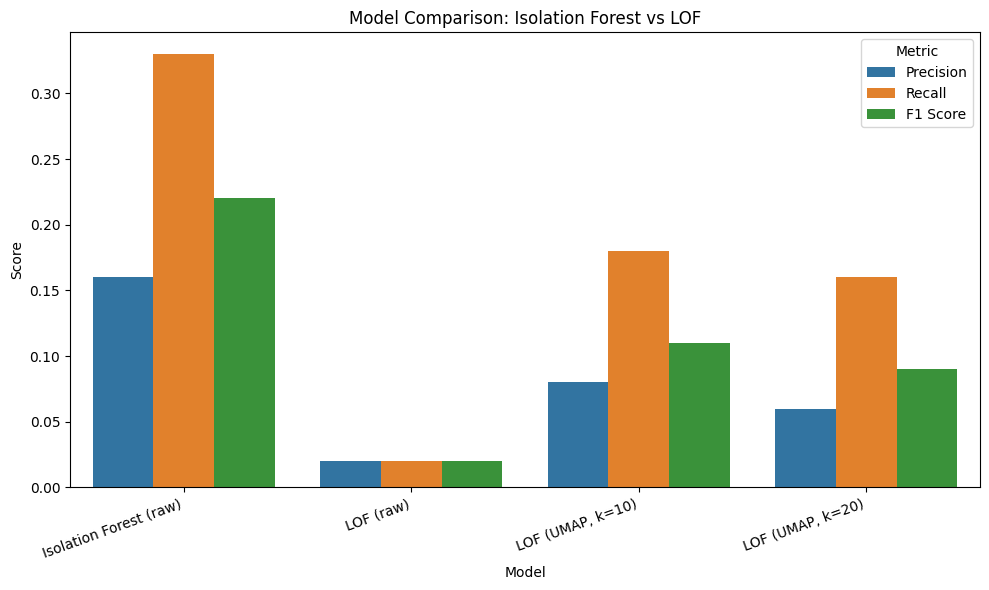

In [59]:
df_melted = df_results.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x="Model", y="Score", hue="Metric")
plt.title("Model Comparison: Isolation Forest vs LOF")
plt.xticks(rotation=20, ha='right')
plt.ylabel("Score")
plt.tight_layout()
plt.show()

Summary of Findings:

1. Isolation Forest (IF) emerged as the most robust model:

    - Achieved F1 score of 0.22, with Recall of 0.27

    - It learns how normal points isolate compared to anomalies, making it sensitive to rare behavior.

    - Performs well in high-dimensional space, where distance metrics may fail.

2. LOF on Raw Data performed poorly:

    - LOF relies on local density estimation and struggled in high dimensions.

    - Resulted in F1 score of just 0.02, indicating almost no contribution in fraud discovery.

3. LOF on UMAP-Reduced Space showed improvement:

    - UMAP helped uncover local structure, increasing recall from 2% to 18%.

    - LOF with n_neighbors=10 was more sensitive, but had trade-offs in precision

How Fraud Was Identified

- Unsupervised Learning Assumption: Trained models only on normal (Class 0) data.

- Anomalies Detected Based on:

    - Isolation Forest: How easily a transaction is separated from others in the feature space.

    - LOF: The density of a point relative to its neighbors — lower density = higher anomaly score.

- Contamination Factor: Controlled the proportion of points assumed to be anomalous (e.g., 0.003 or 0.5%).

- Dimensionality reduction (UMAP) plays a crucial role in boosting density-based models like LOF.

- Isolation Forest remains the preferred baseline due to its scalability, interpretability, and effectiveness in high dimensions.

- Recall is often prioritized in fraud detection, as catching more frauds (even with false positives) is vital for investigation systems.